In [25]:
p = 0.25000000000000001
q = 0.2500000000000001
print('p: {:.1f}'.format(p))
print('q: {:.1f}'.format(q))

p: 0.2
q: 0.3


In [32]:
type(q)

float

## 直近 n個のデータから10分後の終値を予測させる

In [90]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
import oandapyV20.endpoints.instruments as instruments
import datetime
from statistics import mean
from statistics import median
import calendar
import datetime
from math import floor
import time
import threading
import json
import random
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.externals.joblib import dump, load
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import feather
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# OANDA API v20の口座IDとAPIトークン
accountID = "101-009-12789646-001"
access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
# OANDAのデモ口座へのAPI接続
api = API(access_token=access_token, environment="practice")

### 怒濤の関数定義

In [4]:
# APIから取得したレートをPandasのDataFrameへ
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [5]:
def get_data(count, gran, year, month, day, hour, minute, second):
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12789646-001"
    access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=hour, minute=minute, second=second).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from,
#         'dailyAlignment': 0
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [6]:
def get_data_super(start, end, gran):
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12789646-001"
    access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")
    # xxxx-xx-xx～xxxx-xx-xx の期間のデータを取得してデータフレームを返す
    s_year, s_month, s_day, s_hour, s_minute, s_second = map(int, start.split('-'))
    e_year, e_month, e_day, e_hour, e_minute, e_second = map(int, end.split('-'))
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    from_ = datetime.datetime(year=s_year, month=s_month, day=s_day,
                              hour=s_hour, minute=s_minute, second=s_second).strftime(fmt)
    to_ = datetime.datetime(year=e_year, month=e_month, day=e_day,
                            hour=e_hour, minute=e_minute, second=e_second).strftime(fmt)
    df = pd.DataFrame()
    # 5000個制限に引っかからなければこっちの処理
    try:
        params = {
            "granularity": gran,
            'from': from_,
            'to': to_
        }
        r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
        api.request(r)
        df = to_dataframe(r)
    # 引っかかればこっちの処理
    except:
        i = True
        while i:
            df_tmp = get_data(count=5000, gran=gran, year=s_year, month=s_month, day=s_day,
                             hour=s_hour, minute=s_minute, second=s_second)
            df = pd.concat([df, df_tmp], ignore_index=True)
            index = df_tmp.tail(1).index[0]
            s_year = df_tmp.iat[index, 0].year
            s_month = df_tmp.iat[index, 0].month
            s_day = df_tmp.iat[index, 0].day
            s_hour = df_tmp.iat[index, 0].hour
            s_minute = (df_tmp.iat[index, 0].minute + 1) % 60
            s_second = df_tmp.iat[index, 0].second
#             print('{}-{}-{}-{}-{}-{}'.format(s_year, s_month, s_day, s_hour, s_minute, s_second))
            # 5000個ずつ取得してエンド超えたら止める
            if s_year == e_year:
                i = False
        # 止めたらはみ出した分をここで切り落とす
        for i in range(len(df.index) - 5000, len(df.index)):
            if df.iat[i, 0].year == e_year and df.iat[i, 0].month == e_month and df.iat[i, 0].day == e_day:
                df = df[0:i]
                break
    # ボリンジャーバンドを追加
    sigma = 1
    df['BB20,+{}'.format(sigma)] = df['BB20,-{}'.format(sigma)] = 0
    df['BB20,+{}'.format(sigma)] = df['BB20,+{}'.format(sigma)].apply(float)
    df['BB20,-{}'.format(sigma)] = df['BB20,-{}'.format(sigma)].apply(float)
    for i in range(20, len(df)):
        df.iat[i, 6] = round(mean(df['Close'][i-20:i]) + (np.std(df['Close'][i-20:i]) * sigma), 3)
        df.iat[i, 7] = round(mean(df['Close'][i-20:i]) - (np.std(df['Close'][i-20:i]) * sigma), 3)
    # シグナル追加
    df['Lシグナル'] = df['Sシグナル'] = 0
    for i in range(len(df)):
        if df.iat[i, 6] < df.iat[i, 5]:
            df.iat[i, 8] = 1
        if df.iat[i, 7] > df.iat[i, 5]:
            df.iat[i, 9] = 1
    # 移動平均追加
    df['SMA20'] = 0
    df['SMA20'] = df['SMA20'].apply(float)
    for i in range(20, len(df)):
        df.iat[i, 10] = round(mean(df['Close'][i-20:i]), 3)
    # BB と SMA で参照した最初の分を落とす
    df = df[20:]
    df.reset_index(drop=True, inplace=True)
    return df

In [7]:
def get_evaluation(pos_df):
    # 勝率
    win_c = pos_df[pos_df['pips'] >=0].shape[0]
    WP = round(win_c / len(pos_df.index) * 100, 2)
    print('勝率: {}%'.format(WP))
    # ペイオフレシオ
    win_p = mean(pos_df[pos_df['pips'] >=0]['pips'])
    los_p = mean(pos_df[pos_df['pips'] < 0]['pips']) * (-1)
    RR = round(win_p / los_p, 4)
    print('ペイオフレシオ: {}'.format(RR))
    # 期待値
    win_pro = mean(pos_df[pos_df['pips'] >=0]['profit'])
    los_pro = mean(pos_df[pos_df['pips'] < 0]['profit']) * (-1)
    E = round(P * win_pro - pos_df[pos_df['pips'] < 0].shape[0] / len(pos_df.index) * los_pro, 2)
    print('期待値: {}円'.format(E))
    DD = round(pos_df.sort_values(by='profit', ascending=True).iat[0, 5], 2)
    print('最大ドローダウン: -{}円'.format(DD))
    return WP, RR, E, DD

In [8]:
def set_profit(tmp_i, i, pos, entry_rate, exit_rate, assets, df, pos_df, pos_count, lot):
    fee = 0.008
    pos_count+=1
    if pos == 'entry_long':
        pips = (exit_rate - entry_rate - fee) * 100
        l_s = 'long'
    else:
        pips = (entry_rate - exit_rate - fee) * 100
        l_s = 'short'
    profit = lot * 25 * pips / 100
    assets = round(assets + profit, 4)
    tmp_se = pd.Series( [lot, 'long', df.iat[tmp_i,0], entry_rate, df.iat[i+1,0],
                        exit_rate, pips, profit, assets ], index=pos_df.columns )
    pos_df = pos_df.append( tmp_se, ignore_index=True )
    pos = 'None'
    return assets, pos_df, pos_count, pos

In [9]:
# 訓練データ作る関数 (binary用)
def get_dataset_bc(df, n, m):
    LGB_df = pd.DataFrame()
    for i in range(1, n+1):
        diff_tmp = df.iloc[:, [2,3,4,5,6,7,10]].diff(i)*100
        diff_tmp['Volume'] = df.iloc[:, [1]].shift(i)
        diff_tmp['Lシグナル'] = df.iloc[:, [8]].shift(i)
        diff_tmp['Sシグナル'] = df.iloc[:, [9]].shift(i)
        LGB_df = pd.concat([LGB_df, diff_tmp], axis=1)
    LGB_df['y'] = df['Close'].diff(-10)*100
    LGB_df = LGB_df[n:(len(LGB_df)-n)]
    LGB_df_1 = LGB_df[LGB_df['y'] >= m].assign(target=1)
    LGB_df_2 = LGB_df.query('y < {}'.format(m)).assign(target=0)
    LGB_df_c = pd.concat([LGB_df_1, LGB_df_2], axis=0)
    # LGB_df_c.drop(['y'], axis=1, inplace=True)
    # LGB_df_c = LGB_df_c.sample(frac=1, random_state=1729)
    LGB_df_c.reset_index(drop=True, inplace=True)
    return LGB_df_c

### データ読み込み

In [10]:
# df = pd.read_csv('data/df.csv')
df = pd.read_csv('data/df_sma.csv')
# LGB_df = pd.read_csv('data/LGB_df_BB.csv')
# LGB_df = pd.read_csv('data/LGB_df_SMA.csv')
# df_10 = pd.read_csv('data/df_10.csv')
df_5 = pd.read_csv('data/df_5.csv')
df_2017 = pd.read_csv('data/df_2017.csv')

In [0]:
df.head()

,Time,Volume,Open,High,Low,Close,"BB20,+1","BB20,-1",Lシグナル,Sシグナル
0,2018-01-01 22:21:00+00:00,2,112.641,112.641,112.636,112.636,112.673,112.641,0,1
1,2018-01-01 22:22:00+00:00,4,112.642,112.646,112.638,112.646,112.672,112.639,0,0
2,2018-01-01 22:23:00+00:00,9,112.650,112.650,112.633,112.642,112.670,112.638,0,0
3,2018-01-01 22:24:00+00:00,21,112.646,112.646,112.632,112.644,112.668,112.637,0,0
4,2018-01-01 22:25:00+00:00,14,112.639,112.656,112.634,112.634,112.667,112.636,0,1


In [0]:
LGB_df.head()

,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,...,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,Open,High,Low,Close,"BB20,+1","BB20,-1",SMA20,Volume,Lシグナル,Sシグナル,y
10,-0.004,-0.001,-0.011,-0.008,0.000,-0.002,-0.001,13.0,0.0,1.0,-0.017,-0.023,-0.037,-0.015,-0.001,-0.004,-0.002,6.0,0.0,1.0,-0.022,-0.034,-0.017,-0.025,-0.001,-0.005,-0.003,43.0,0.0,0.0,-0.014,-0.038,-0.040,-0.021,-0.002,-0.007,-0.004,82.0,0.0,1.0,...,-0.028,-0.043,-0.033,-0.004,-0.010,-0.006,21.0,0.0,0.0,-0.035,-0.032,-0.044,-0.031,-0.006,-0.011,-0.008,9.0,0.0,0.0,-0.027,-0.028,-0.049,-0.035,-0.008,-0.012,-0.010,4.0,0.0,0.0,-0.026,-0.023,-0.047,-0.025,-0.009,-0.014,-0.011,2.0,0.0,1.0,0.006
11,-0.009,-0.012,0.015,-0.007,0.000,-0.003,-0.002,15.0,0.0,1.0,-0.013,-0.013,0.004,-0.015,0.000,-0.005,-0.003,13.0,0.0,1.0,-0.026,-0.035,-0.022,-0.022,-0.001,-0.007,-0.004,6.0,0.0,1.0,-0.031,-0.046,-0.002,-0.032,-0.001,-0.008,-0.005,43.0,0.0,0.0,...,-0.050,-0.030,-0.030,-0.003,-0.012,-0.008,14.0,0.0,1.0,-0.040,-0.040,-0.028,-0.040,-0.004,-0.013,-0.008,21.0,0.0,0.0,-0.044,-0.044,-0.029,-0.038,-0.006,-0.014,-0.010,9.0,0.0,0.0,-0.036,-0.040,-0.034,-0.042,-0.008,-0.015,-0.012,4.0,0.0,0.0,-0.004
12,0.002,0.010,-0.010,0.001,0.001,-0.003,-0.001,2.0,0.0,1.0,-0.007,-0.002,0.005,-0.006,0.001,-0.006,-0.003,15.0,0.0,1.0,-0.011,-0.003,-0.006,-0.014,0.001,-0.008,-0.004,13.0,0.0,1.0,-0.024,-0.025,-0.032,-0.021,0.000,-0.010,-0.005,6.0,0.0,1.0,...,-0.035,-0.036,-0.029,-0.002,-0.014,-0.008,84.0,0.0,1.0,-0.031,-0.040,-0.040,-0.029,-0.002,-0.015,-0.009,14.0,0.0,1.0,-0.038,-0.030,-0.038,-0.039,-0.003,-0.016,-0.009,21.0,0.0,0.0,-0.042,-0.034,-0.039,-0.037,-0.005,-0.017,-0.011,9.0,0.0,0.0,0.000
13,-0.006,-0.014,0.008,-0.003,-0.001,-0.003,-0.002,23.0,0.0,1.0,-0.004,-0.004,-0.002,-0.002,0.000,-0.006,-0.003,2.0,0.0,1.0,-0.013,-0.016,0.013,-0.009,0.000,-0.009,-0.005,15.0,0.0,1.0,-0.017,-0.017,0.002,-0.017,0.000,-0.011,-0.006,13.0,0.0,1.0,...,-0.054,-0.027,-0.030,-0.002,-0.016,-0.009,82.0,0.0,1.0,-0.028,-0.049,-0.028,-0.032,-0.003,-0.017,-0.010,84.0,0.0,1.0,-0.037,-0.054,-0.032,-0.032,-0.003,-0.018,-0.011,14.0,0.0,1.0,-0.044,-0.044,-0.030,-0.042,-0.004,-0.019,-0.011,21.0,0.0,0.0,0.013
14,-0.002,0.000,-0.020,0.000,0.000,-0.003,-0.001,1.0,0.0,1.0,-0.008,-0.014,-0.012,-0.003,-0.001,-0.006,-0.003,23.0,0.0,1.0,-0.006,-0.004,-0.022,-0.002,0.000,-0.009,-0.004,2.0,0.0,1.0,-0.015,-0.016,-0.007,-0.009,0.000,-0.012,-0.006,15.0,0.0,1.0,...,-0.050,-0.024,-0.034,-0.001,-0.017,-0.009,43.0,0.0,0.0,-0.029,-0.054,-0.047,-0.030,-0.002,-0.019,-0.010,82.0,0.0,1.0,-0.030,-0.049,-0.048,-0.032,-0.003,-0.020,-0.011,84.0,0.0,1.0,-0.039,-0.054,-0.052,-0.032,-0.003,-0.021,-0.012,14.0,0.0,1.0,0.008


### LGB用のデータ作成

In [0]:
df = get_data_super(start='2018-01-01-00-00-00', end='2019-01-01-00-00-00', gran='M1')

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


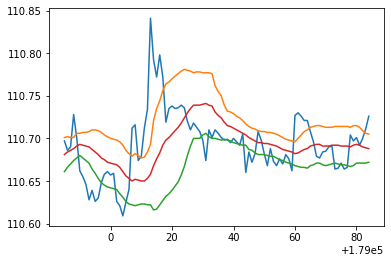

In [0]:
fig, ax = plt.subplots()
ax.plot(df['Close'][i:i+100])
ax.plot(df['BB20,+1'][i:i+100])
ax.plot(df['BB20,-1'][i:i+100])
ax.plot(df['SMA20'][i:i+100])
plt.show()

In [0]:
i = 179000-15
df[i:i+10]

,Time,Volume,Open,High,Low,Close,"BB20,+1","BB20,-1",Lシグナル,Sシグナル,SMA20
178985,2018-06-29 20:56:00+00:00,15,110.712,110.712,110.690,110.697,110.701,110.661,0,0,110.681
178986,2018-06-29 20:57:00+00:00,8,110.694,110.694,110.686,110.686,110.702,110.666,0,0,110.684
178987,2018-06-29 20:58:00+00:00,5,110.688,110.690,110.684,110.690,110.701,110.670,0,0,110.686
178988,2018-06-29 20:59:00+00:00,9,110.690,110.728,110.689,110.728,110.701,110.674,1,0,110.688
178989,2018-07-01 21:00:00+00:00,7,110.675,110.701,110.624,110.701,110.706,110.677,0,0,110.691
178990,2018-07-01 21:01:00+00:00,11,110.705,110.705,110.636,110.662,110.706,110.680,0,1,110.693
178991,2018-07-01 21:02:00+00:00,11,110.662,110.668,110.642,110.655,110.707,110.677,0,1,110.692
178992,2018-07-01 21:03:00+00:00,2,110.650,110.650,110.646,110.646,110.707,110.674,0,1,110.691
178993,2018-07-01 21:04:00+00:00,7,110.641,110.641,110.622,110.628,110.708,110.671,0,1,110.690
178994,2018-07-01 21:05:00+00:00,60,110.633,110.640,110.621,110.639,110.710,110.664,0,1,110.687


In [0]:
# 2018-07-01 ～ 2018-12-31
df_7_12 = df[178989:]

In [0]:
# LGB_df.to_csv('LGB_df_BB.csv', index=False)
df.to_csv('df_sma.csv', index=False)

In [0]:
LGB_df.to_csv('LGB_df_SMA.csv', index=False)

In [0]:
LGB_df = pd.read_csv('LGB_df_BB.csv')

In [0]:
LGB_df_s = LGB_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [0]:
LGB_df.loc[0, ['Close.9']]
# 110.658

Close.9    110.658
Name: 0, dtype: float64

### 二値分類

In [11]:
LGB_df_bc = get_dataset_bc(df, 50, 10)
# LGB_df_bc

In [51]:
LGB_df_bc.columns = map(str, range(502))
X = LGB_df_bc.drop(['500', '501'], axis=1).to_numpy()
y = LGB_df_bc[['501']].to_numpy().flatten()
# X_train, X_test, y_train, y_test = imbalanced_data_split(X.to_numpy(), y.to_numpy().flatten(), test_size=0.3)
# # for validation
# X_train2, X_valid, y_train2, y_valid = imbalanced_data_split(X_train, y_train, test_size=0.3)

In [92]:
lgbm_params = {
    'objective': 'binary',
    'metric': 'auc',
    'seed': 1729,
    'learning_rate': 0.05,
    'num_boosting_round': 2000
}

def lgbm_train(X_train_df, X_valid_df, y_train_df, y_valid_df, lgbm_params):
    lgb_train = lgb.Dataset(X_train_df, y_train_df)
    lgb_eval = lgb.Dataset(X_valid_df, y_valid_df, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    model = lgb.train(lgbm_params, lgb_train,
                      # モデルの評価用データを渡す
                      valid_sets=lgb_eval,
                      # 最大で 1000 ラウンドまで学習する
                      num_boost_round=1000,
                      # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                      early_stopping_rounds=10,
                      # うるさいので黙らせる
                      verbose_eval = False)
    
    return model

def skf_score(X, y, seed):
    SKF = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    auc_l = []
    for train_index, test_index in SKF.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=seed, stratify=y_train)
        lgb_train = lgb.Dataset(X_train2, y_train2)
        lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
        LGB = lgb.train(lgbm_params, lgb_train,
                        # モデルの評価用データを渡す
                        valid_sets=lgb_eval,
                        # 最大で 1000 ラウンドまで学習する
                        num_boost_round=1000,
                        # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                        early_stopping_rounds=10,
                        # うるさいので黙らせる
                        verbose_eval = False)
        y_pred = LGB.predict(X_test, num_iteration=LGB.best_iteration)
        auc = metrics.roc_auc_score(y_test, y_pred)
        auc_l.append(auc)
    score = mean(auc_l)
    return score

#### UnderSampling

In [71]:
rus = RandomUnderSampler(random_state=1729)
X_resampled, y_resampled = rus.fit_resample(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [60]:
rus_score = skf_score(X_resampled, y_resampled, 1729)
print(rus_score)
# 0.7909138413925111 seed = 1729
# 0.7922117833553429 seed = 42
# 0.7904243801875719 seed = 36

0.7919845885215586


#### UnderSampling + bagging

In [62]:
def bagging(seed):
    rus = RandomUnderSampler(random_state=seed)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    X_train2, X_valid, y_train2, y_valid = train_test_split(X_resampled, y_resampled,
                                                            test_size=0.3, random_state=seed, stratify=y_resampled)
    model_bagging = lgbm_train(X_train2, X_valid, y_train2, y_valid, lgbm_params)
    return model_bagging

In [63]:
models = []

for i in range(10):
    models.append(bagging(i))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, cate

In [66]:
y_preds = []

for m in models:
    y_preds.append(m.predict(X_test, num_iteration=m.best_iteration))

y_preds_bagging = sum(y_preds)/len(y_preds)
# auc を計算する
auc = metrics.roc_auc_score(y_test, y_preds_bagging)
print(auc)

0.874687259490223


#### OverSampling

In [98]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MemoryError: 

In [74]:
ros_score = skf_score(X_resampled, y_resampled, 1729)
print(ros_score)

0.9986689616073141


SMOTE

In [79]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [81]:
X.shape

(356678, 500)

In [86]:
X_resampled.shape

(703534, 500)

In [96]:
X_resampled

(500,)

In [97]:
smote_score = skf_score(X_resampled, y_resampled, 1729)
print(smote_score)

MemoryError: 

LightGBM: scale_pos_weight